#  ML attacks and sensors

### Imports & functions

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from scipy.stats import loguniform
import numpy as np
import seaborn as sns
import pandas as pd

sns.set(font_scale=2.5)

local_options = {
    'plot_confusion': True,
    'multi_class'   : False,
    'features_importance': True
    }

models = [
          ('Logistic Regression', LogisticRegression(solver='liblinear')), 

          ('Random Forest', RandomForestClassifier()),
          #('Random Forest', RandomForestClassifier(n_estimators=70, max_features=6)),

          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC(kernel='linear')), 
        ]

In [4]:
param_distr = {"Logistic Regression": {'penalty' : ['l1', 'l2'],
                                        'C' : loguniform(1e-5, 100),
                                        'solver' : ['newton-cg', 'lbfgs', 'liblinear']},
               "Random Forest": {'n_estimators' : list(range(10,101,10)),
                                  'max_features' : list(range(6,32,5))}, # add iterations
               "SVM": {'C': np.linspace(0.1,101,100)}
              }

def params_research(X_train, y_train):
    for name, model in models:
        print(name)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
        search = RandomizedSearchCV(model, param_distr[name], n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
        result = search.fit(X, y)
        #kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=92722)
        #clf = RandomizedSearchCV(model, param_distr, cv=kfold, random_state=1238, scoring='accuracy')
        #search = clf.fit(X_train, y_train)
        print(result.best_score_)
        print(result.best_params_)

In [5]:
# Logistic regression: C=3, solver=liblinear
# Random Forest: n_estimators=70, max_features=6
#params_research(X, y)

In [3]:
def run_exps(X_train, y_train, X_test, y_test, img_name):
    dfs = []
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,30))
    fig.suptitle(img_name)
    plt.rcParams.update({'font.size': 22})
    results = []
    names = []
    feature_result = {}
    
    if local_options['multi_class']:
        target_names = ['Bulb', 'Camera', 'Fire', 'Plug', 'SmartTv', 'Thermo',  'Connect', 'Quick', 'Heavy']
        scoring = ['f1_macro','precision_macro']
    else:
        target_names = ['NotAttack', 'Attack']
        scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
        
    for (name, model), ax in zip(models, axes.flat):
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=92722)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print("Model ", name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
    
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
        if local_options['features_importance']:
            if name == "Logistic Regression":
                importance = model.coef_[0]
                feature_result[name] = importance

            if name == "Random Forest":
                importance = model.feature_importances_
                feature_result[name] = importance

            #if name == "KNN":
                #results = permutation_importance(model, X_train, y_train, scoring='accuracy')
                #importance = results.importances_mean
                #feature_result[name] = importance

            if name == "SVM":
                importance = model.coef_
                feature_result[name] = importance

            
        
        if local_options['plot_confusion']:
            pcm = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Purples, display_labels = target_names, ax=ax, normalize='true')
            pcm.ax_.set_title(name)
            ax.grid(False)
    
    plt.savefig("images/{}.png".format(img_name))
    plt.show()
    final = pd.concat(dfs, ignore_index=True)
    return final, feature_result

### Los geht's

In [176]:
# read dataframe from...
df = pd.read_csv('ml_dataset.csv')
df

,TotPkts,SrcPkts,DstPkts,TotBytes,SrcBytes,DstBytes,Dur,Load,SrcLoad,DstLoad,...,Type,Dir_->,Dir_<?,Dir_<?>,Dir_?>,State_ACC,State_CON,State_FIN,State_REQ,State_RST
0,0.003981,0.004292,0.003215,0.000522,0.000455,0.003149,0.831979,0.000113,0.000098,0.000015,...,1,1,0,0,0,0,0,0,0,1
1,0.001810,0.001717,0.003215,0.000293,0.000226,0.002987,0.000409,0.111275,0.082299,0.028974,...,1,1,0,0,0,0,1,0,0,0
2,0.014839,0.002575,0.057878,0.035688,0.000319,0.912001,0.888872,0.007976,0.000059,0.007911,...,1,1,0,0,0,0,1,0,0,0
3,0.001810,0.000858,0.006431,0.000306,0.000119,0.005974,0.819433,0.000058,0.000014,0.000043,...,1,1,0,0,0,1,0,0,0,0
4,0.001810,0.000858,0.006431,0.000287,0.000106,0.005813,0.103401,0.000437,0.000102,0.000334,...,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37405,0.283388,0.185408,0.565916,0.978070,0.986915,0.468898,0.995814,0.200237,0.196555,0.003724,...,1,1,0,0,0,0,1,0,0,0
37406,0.189287,0.201717,0.086817,0.152644,0.154111,0.071933,0.156705,0.198612,0.195081,0.003573,...,1,1,0,0,0,0,0,0,0,1
37407,0.098082,0.069528,0.176849,0.258937,0.260397,0.147015,0.304940,0.172456,0.168703,0.003789,...,1,1,0,0,0,0,0,0,0,1
37408,0.327543,0.211159,0.665595,0.985801,0.991546,0.551972,0.999363,0.201160,0.196831,0.004370,...,1,1,0,0,0,0,1,0,0,0


### Full dataset

In [5]:
if local_options['multi_class']:
    y = df.Sensor
else: 
    y = df.Type

X = df.drop(['Type', 'Sensor'] , axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=8675309, shuffle=True)

Model  Logistic Regression
              precision    recall  f1-score   support

   NotAttack       0.88      0.98      0.93      8863
      Attack       0.97      0.81      0.88      6101

    accuracy                           0.91     14964
   macro avg       0.92      0.90      0.91     14964
weighted avg       0.92      0.91      0.91     14964

Model  Random Forest
              precision    recall  f1-score   support

   NotAttack       0.98      1.00      0.99      8863
      Attack       0.99      0.97      0.98      6101

    accuracy                           0.98     14964
   macro avg       0.99      0.98      0.98     14964
weighted avg       0.98      0.98      0.98     14964

Model  KNN
              precision    recall  f1-score   support

   NotAttack       0.97      0.99      0.98      8863
      Attack       0.99      0.95      0.97      6101

    accuracy                           0.98     14964
   macro avg       0.98      0.97      0.98     14964
weighted avg   

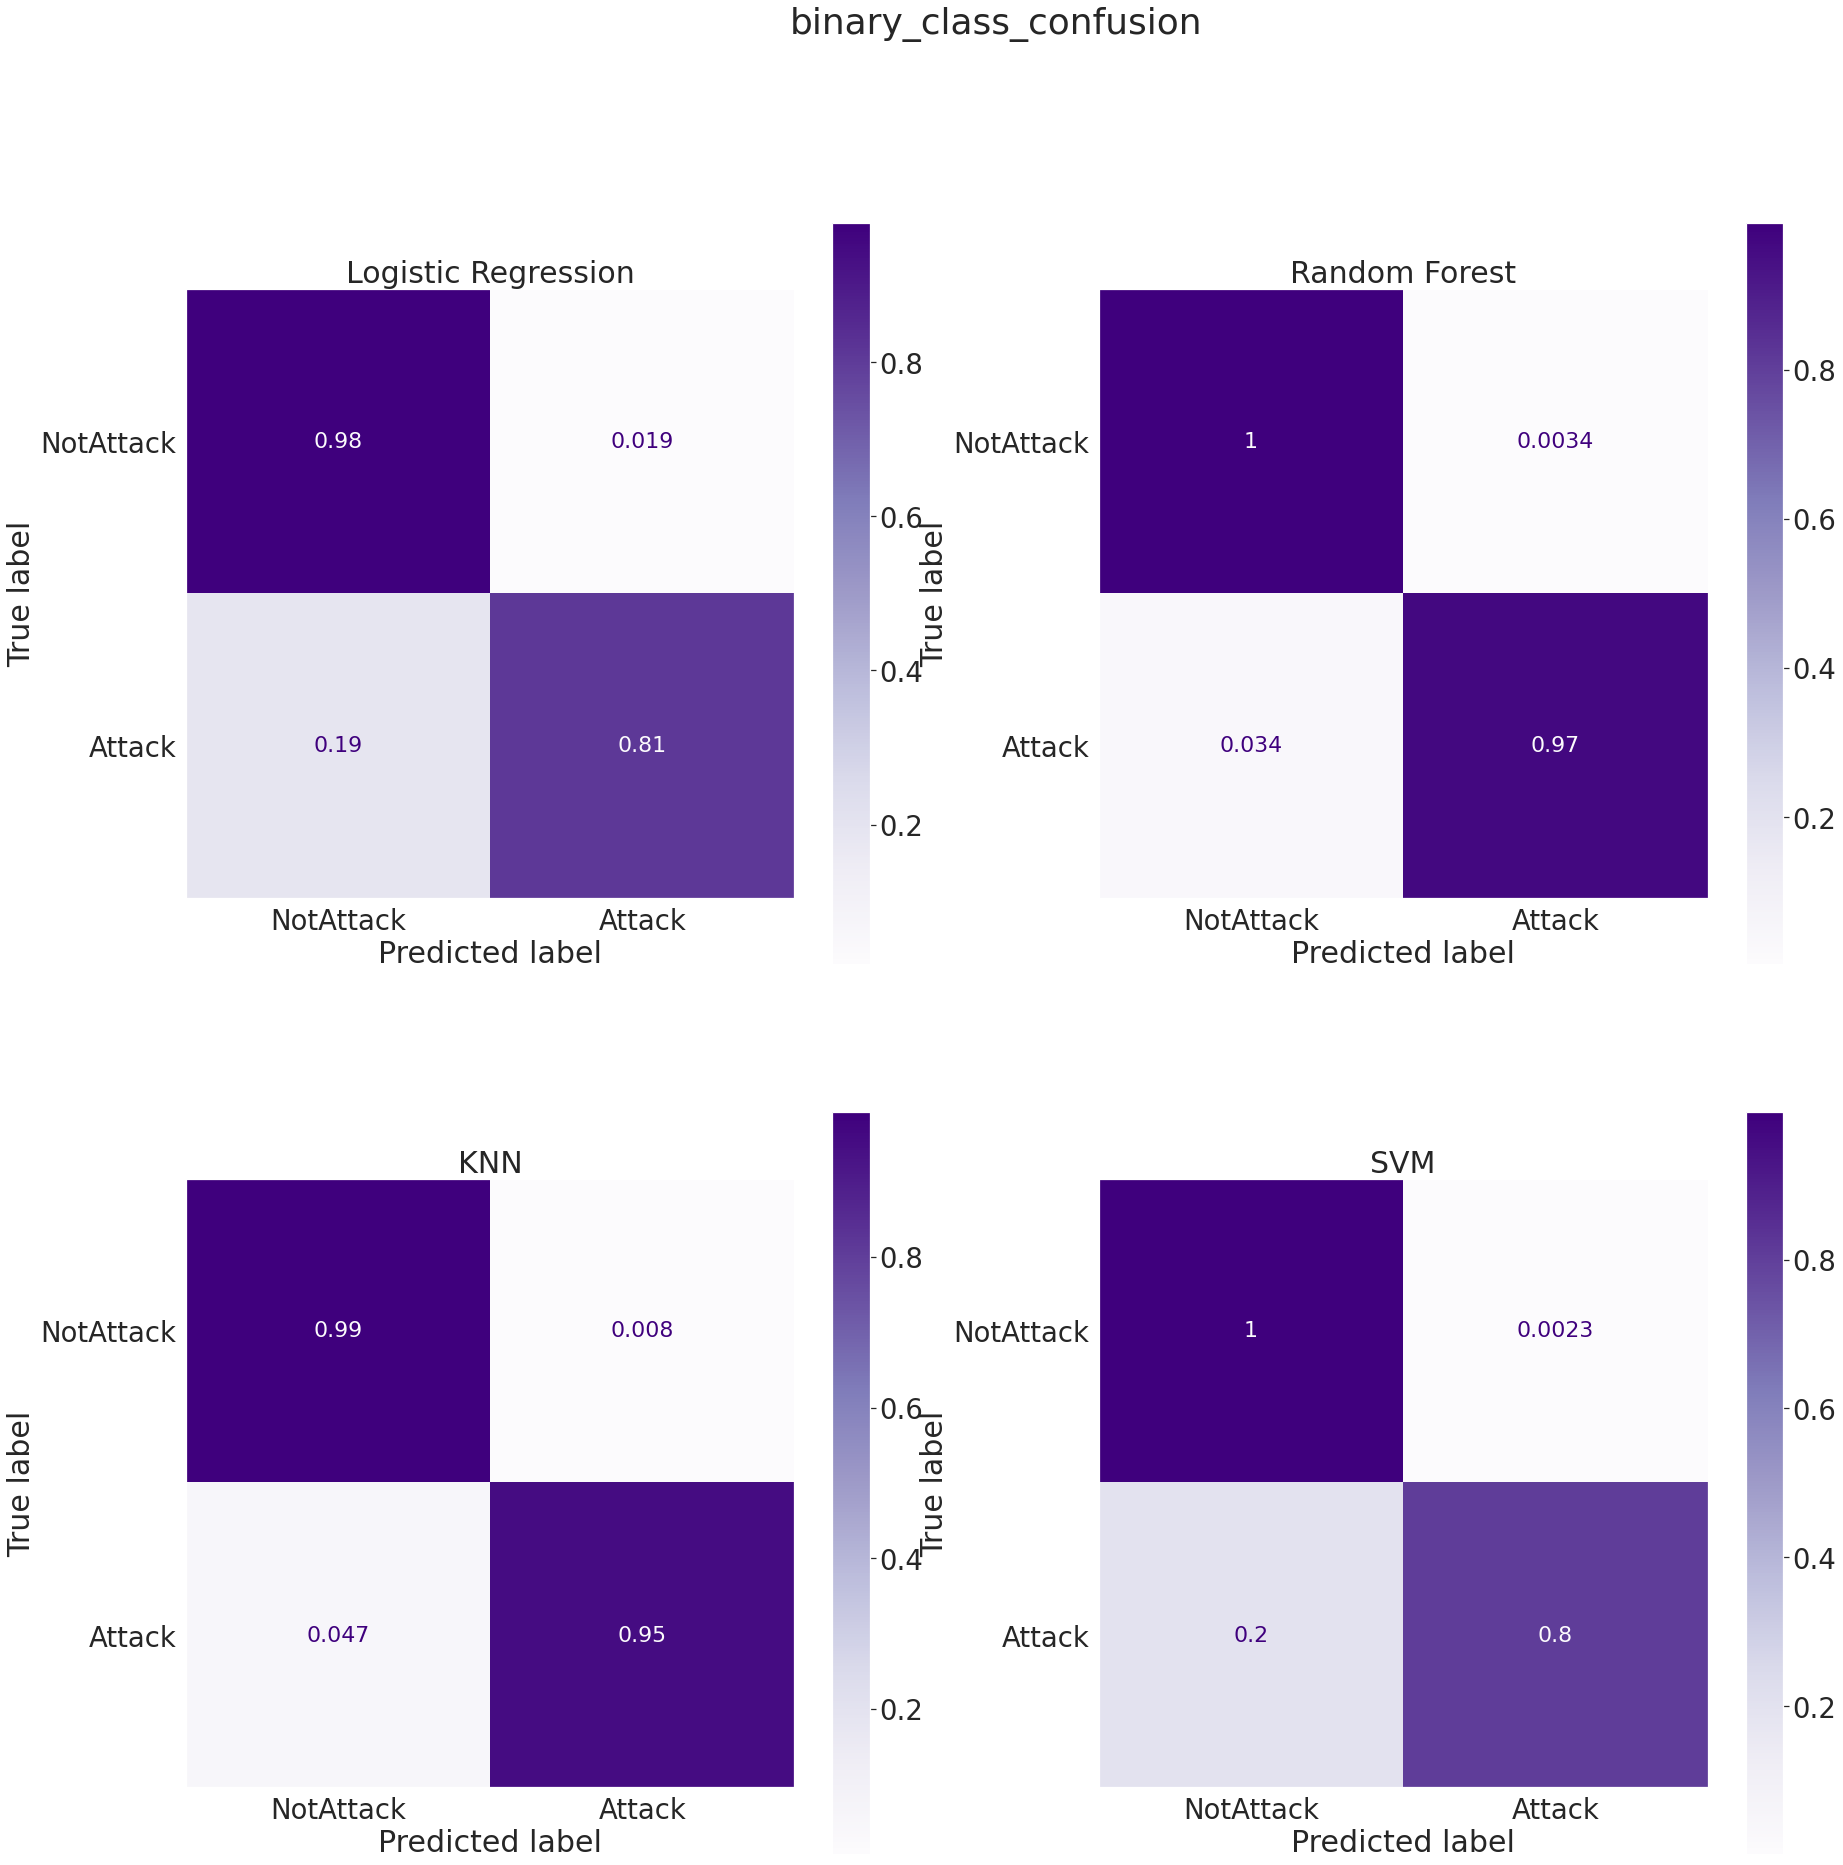

In [6]:
final, features = run_exps(X_train, y_train, X_test, y_test, "binary_class_confusion")

#### Feature importance

In [147]:
import matplotlib as mpl

def feature_importance(features, _x, img_name):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
    fig.tight_layout() 
    plt.subplots_adjust(hspace = .5)
    #import matplotlib.style
    #mpl.style.use('classic')
    #sns.set(font_scale=2)
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.suptitle("Feature importance", y=1.05, size=20)

    for (name, feat), ax in zip(features.items(), axes.flatten()):
        #for i,v in enumerate(feat.flatten()):
        #   print('Feature: %0d, Score: %.5f' % (i,v))

        ax.bar([x for x in range(len(feat.flatten()))], feat.flatten())
        ax.set_title(name)
        ax.yaxis.grid(True)
        ax.set_ylabel("Importance")
        ax.set_xticks(range(0,len(_x.columns)))
        ax.set_xticklabels(_x.columns, rotation = 90, ha="center")

    plt.savefig("images/{}.png".format(img_name))
    plt.show()

In [141]:
def draw_metrics(final, img_name):
    bootstraps = []
    for model in list(set(final.model.values)):
        model_df = final.loc[final.model == model]
        bootstrap = model_df.sample(n=30, replace=True)
        bootstraps.append(bootstrap)

    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] 

    # PERFORMANCE METRICS
    results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] 
    results_long_nofit = results_long_nofit.sort_values(by='values')

    plt.figure(figsize=(13, 6))
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
    plt.legend(loc="lower right", prop={'size': 10})
    plt.suptitle('Comparison of Model by Classification Metric: {}'.format(img_name), size=20)
    plt.grid()
    plt.savefig("images/{}.png".format(img_name))
    plt.show()

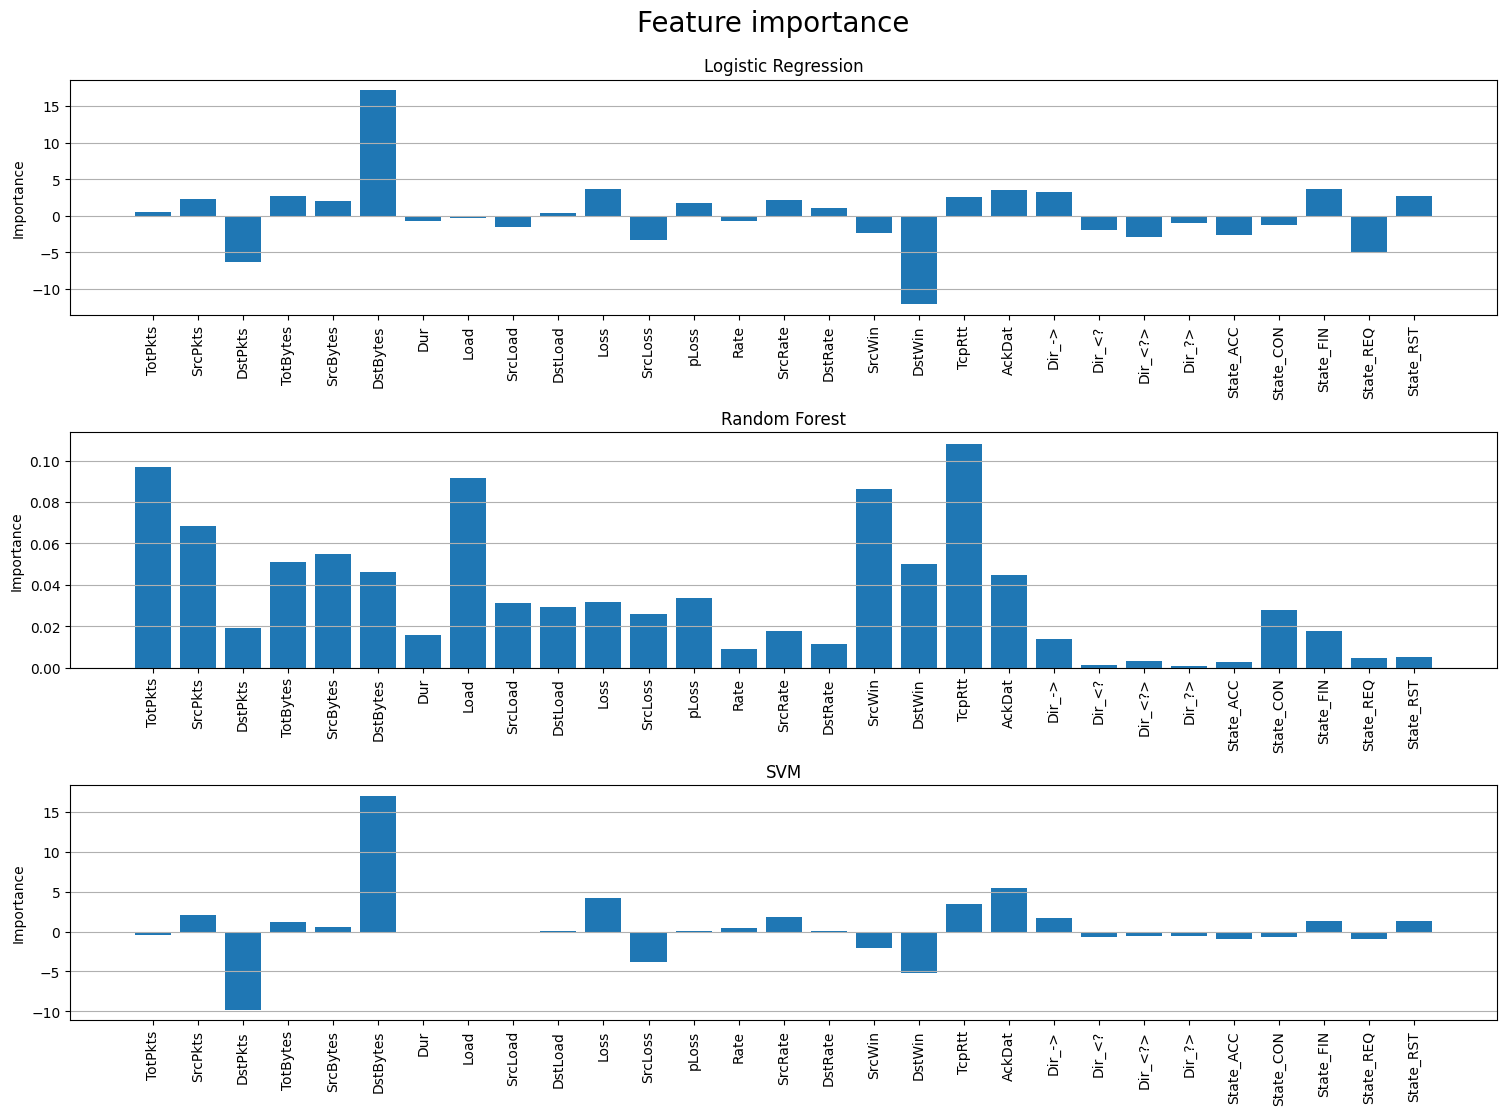

In [148]:
feature_importance(features, X, "binary_features")

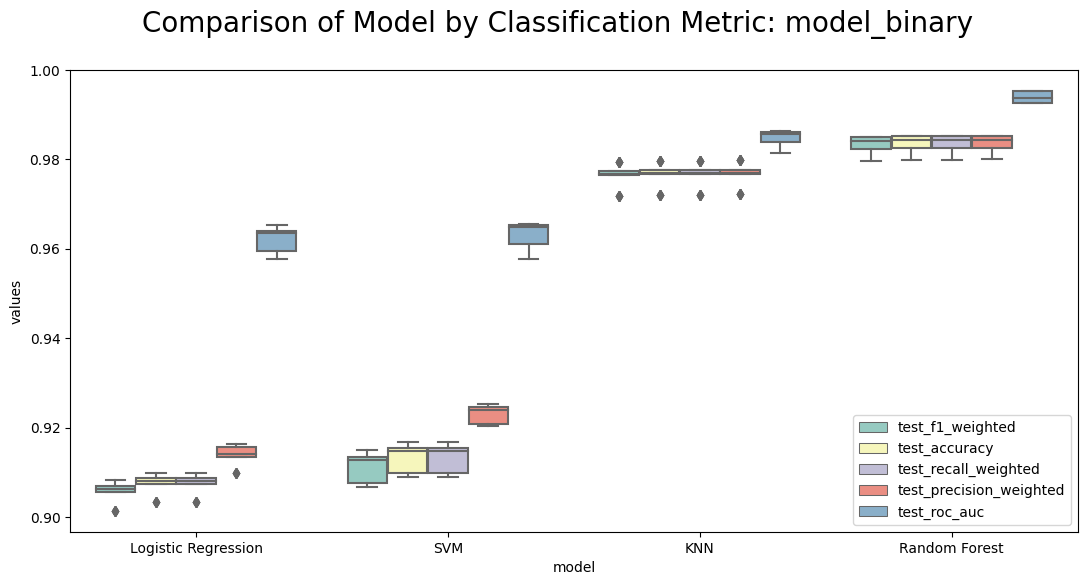

In [177]:
draw_metrics(final, "model_binary")

In [165]:
def model_time(final, img_name):
    bootstraps = []
    for model in list(set(final.model.values)):
        model_df = final.loc[final.model == model]
        bootstrap = model_df.sample(n=30, replace=True)
        bootstraps.append(bootstrap)

    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    results_long = pd.melt(bootstrap_df,id_vars=['model'], var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] 

    # TIME METRICS
    results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] 
    results_long_fit = results_long_fit.sort_values(by='values')
    
    averaged_time = results_long_fit.groupby(['model','metrics']).mean()
    list(averaged_time.index.get_level_values('model').unique())
    averaged_time[averaged_time.index.get_level_values('metrics') == 'fit_time'].values.flatten()
    plt.figure(figsize=(15,7))
    ax = plt.gca()
    plt.ylabel('seconds')
    total_time = (averaged_time[averaged_time.index.get_level_values('metrics') == 'fit_time'].values.flatten() + averaged_time[averaged_time.index.get_level_values('metrics') == 'score_time'].values.flatten() )* 10
    plt.bar(list(averaged_time.index.get_level_values('model').unique()), 
            total_time, color=['r', 'g', 'b', 'y'])

    plt.suptitle("Model time")
    
    ax.yaxis.grid(True)
    plt.savefig("images/{}.png".format(img_name))
    plt.show()

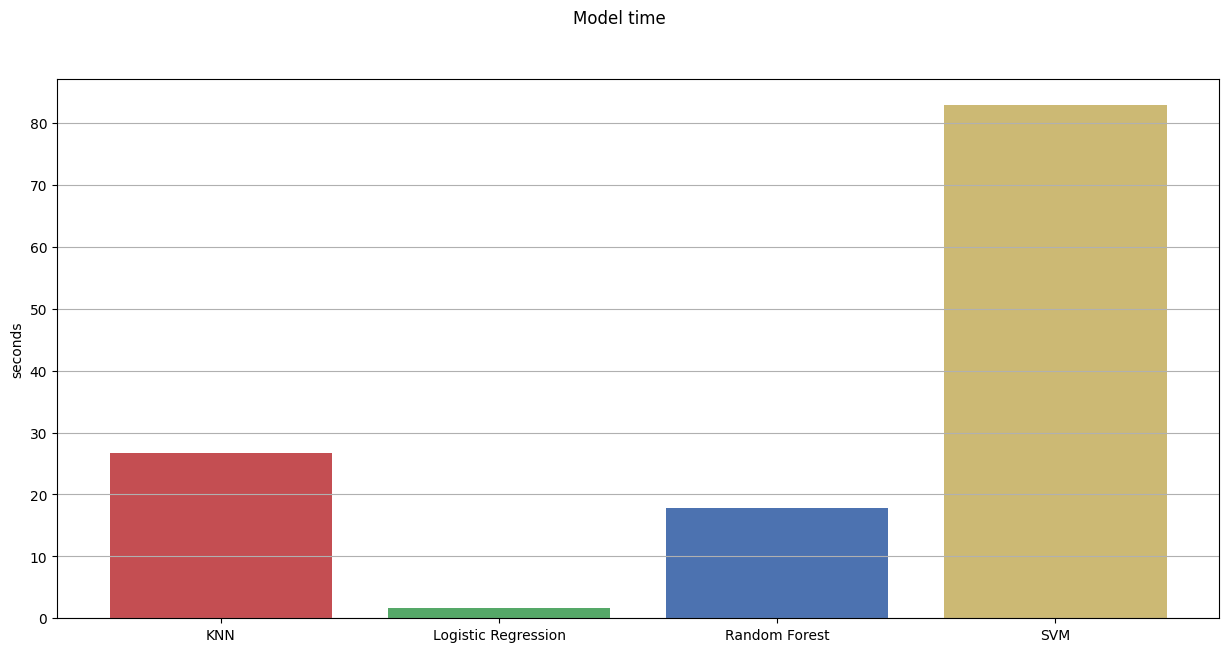

In [166]:
model_time(final, "train_fit_time")

### Only Source features

In [107]:
print(X.columns)
src_X = X[['SrcPkts', 'SrcBytes', 'SrcLoad', 'SrcLoss', 'SrcRate', 'SrcWin']]

Index(['TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes',
       'Dur', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'pLoss', 'Rate',
       'SrcRate', 'DstRate', 'SrcWin', 'DstWin', 'TcpRtt', 'AckDat', 'Dir_->',
       'Dir_<?', 'Dir_<?>', 'Dir_?>', 'State_ACC', 'State_CON', 'State_FIN',
       'State_REQ', 'State_RST'],
      dtype='object')


Model  Logistic Regression
              precision    recall  f1-score   support

   NotAttack       0.70      0.93      0.80      8863
      Attack       0.80      0.44      0.56      6101

    accuracy                           0.73     14964
   macro avg       0.75      0.68      0.68     14964
weighted avg       0.75      0.73      0.70     14964

Model  Random Forest
              precision    recall  f1-score   support

   NotAttack       0.96      0.97      0.97      8863
      Attack       0.96      0.95      0.95      6101

    accuracy                           0.96     14964
   macro avg       0.96      0.96      0.96     14964
weighted avg       0.96      0.96      0.96     14964

Model  KNN
              precision    recall  f1-score   support

   NotAttack       0.96      0.97      0.96      8863
      Attack       0.95      0.94      0.95      6101

    accuracy                           0.96     14964
   macro avg       0.96      0.96      0.96     14964
weighted avg   

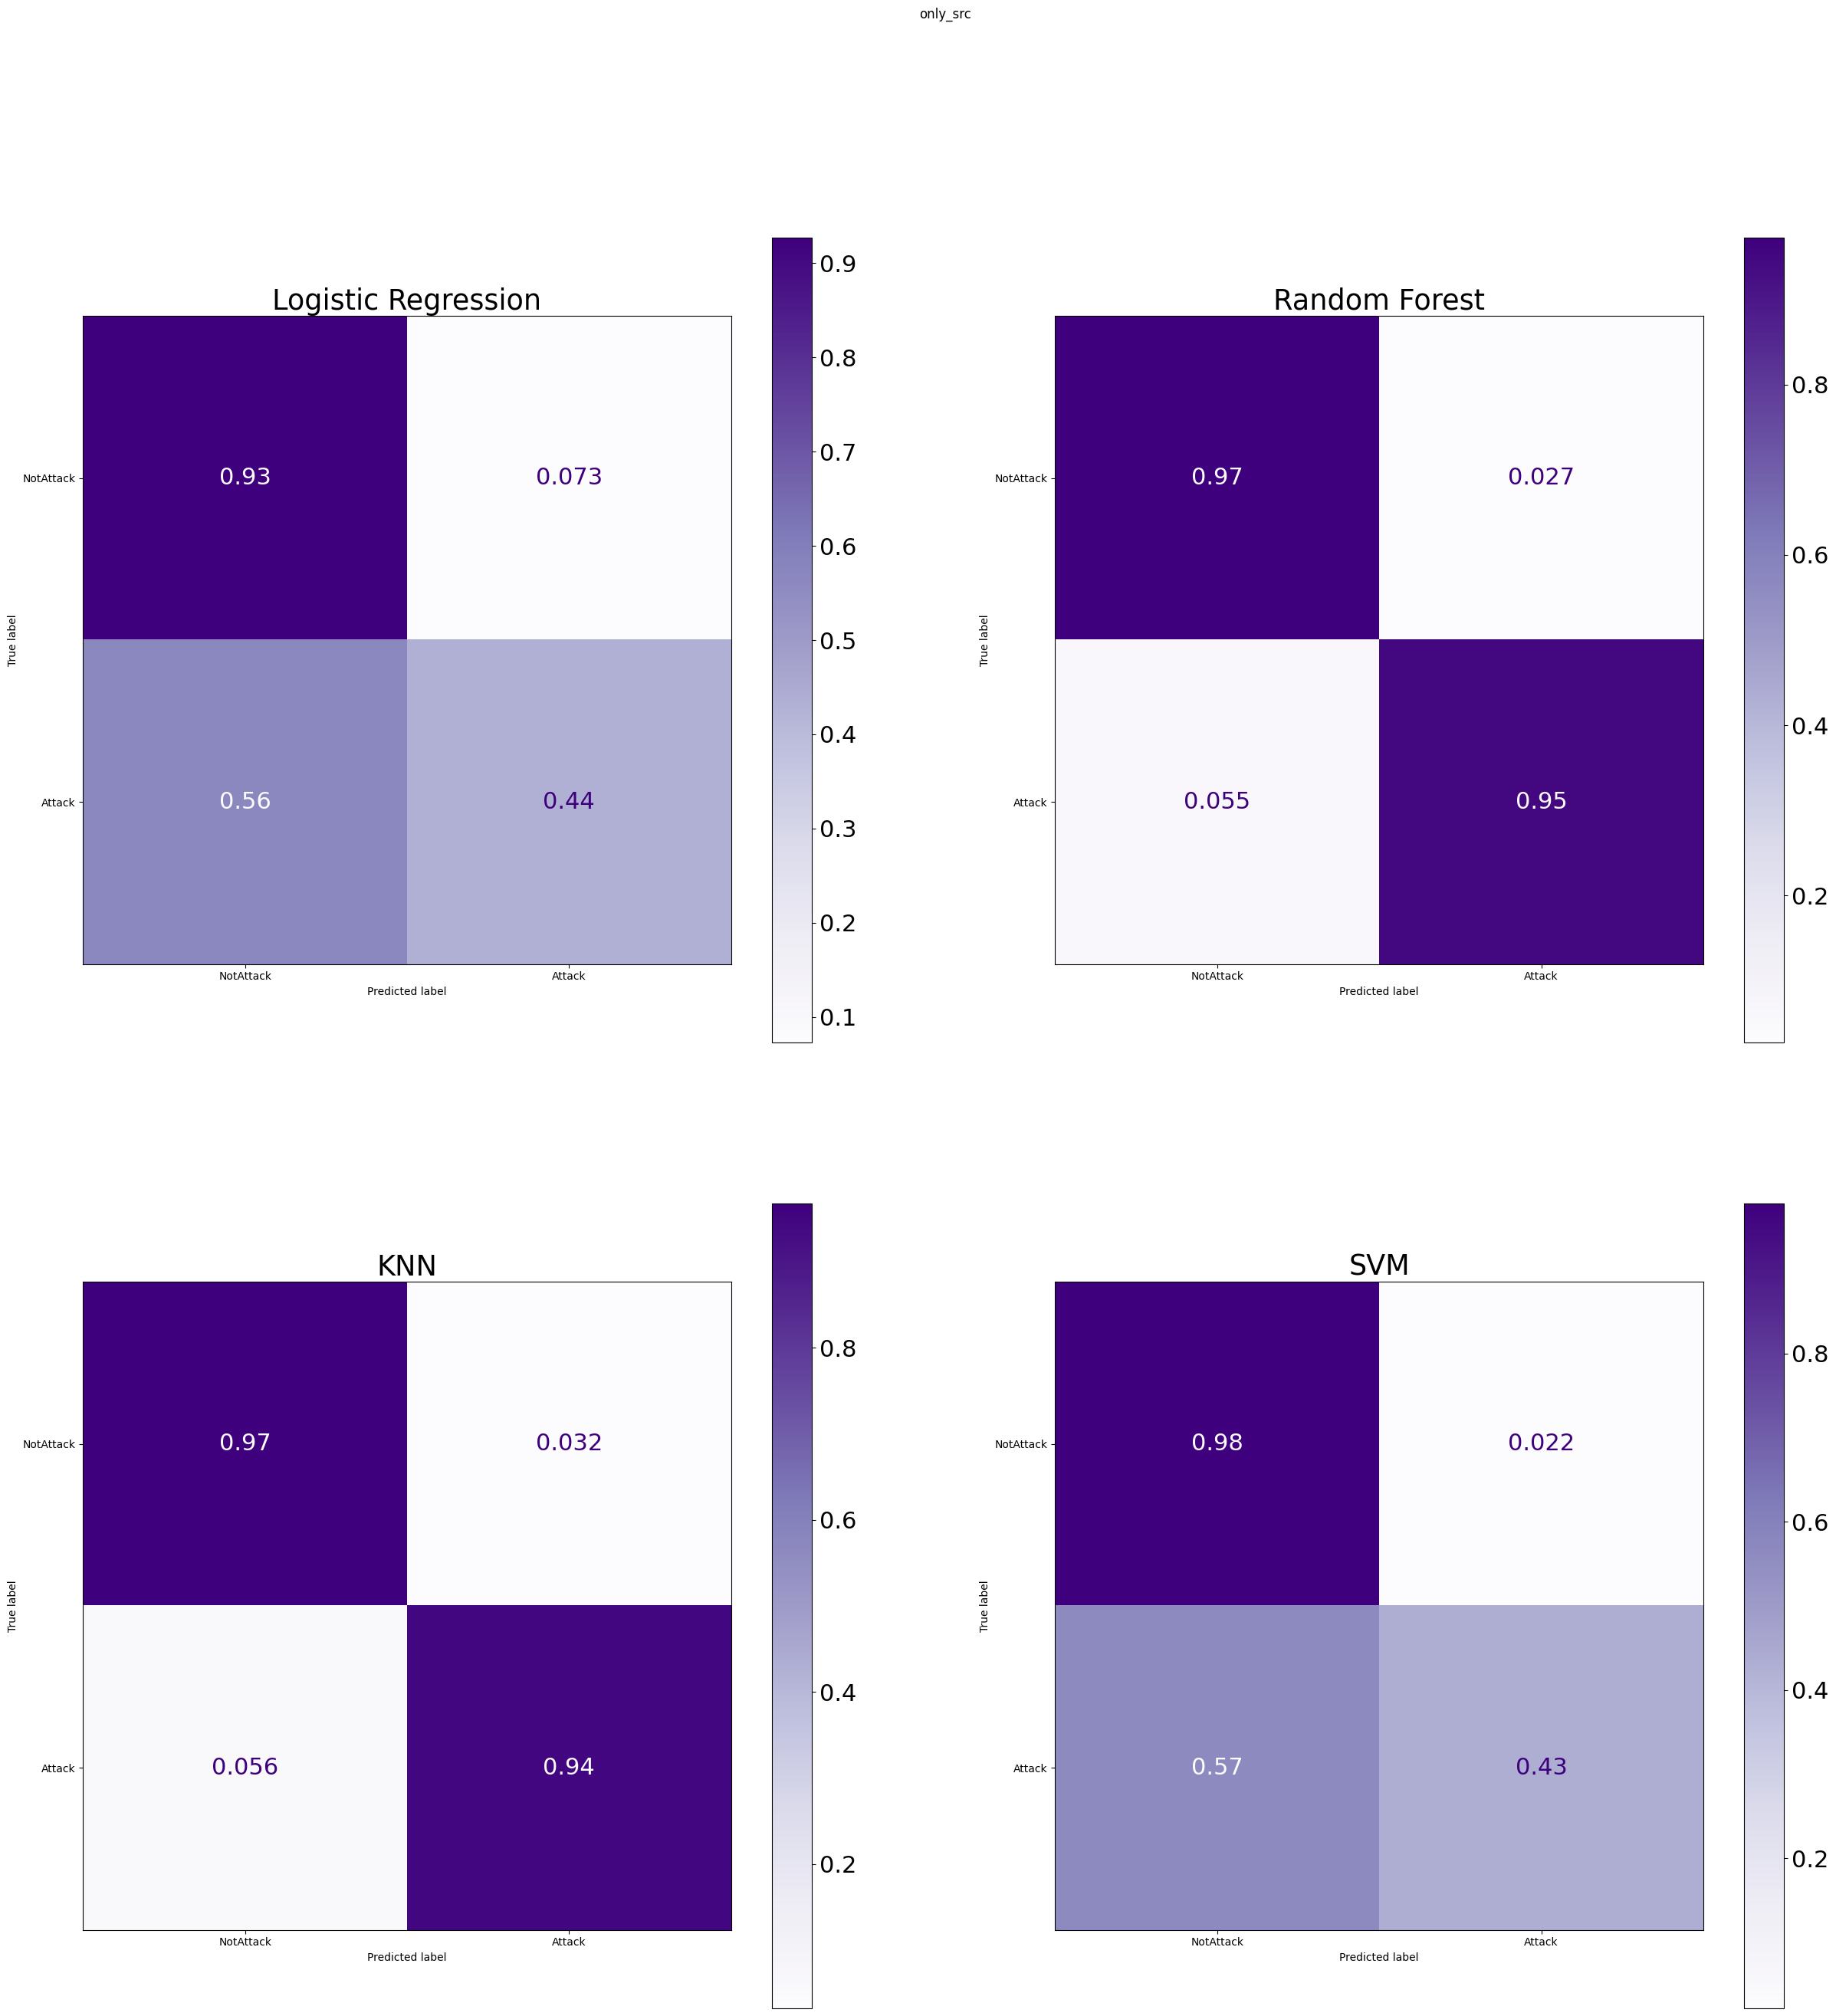

In [109]:
X_train, X_test, y_train, y_test = train_test_split(src_X, y, test_size=0.40, random_state=8675309, shuffle=True)
final_src, features_src = run_exps(X_train, y_train, X_test, y_test, "only_src")

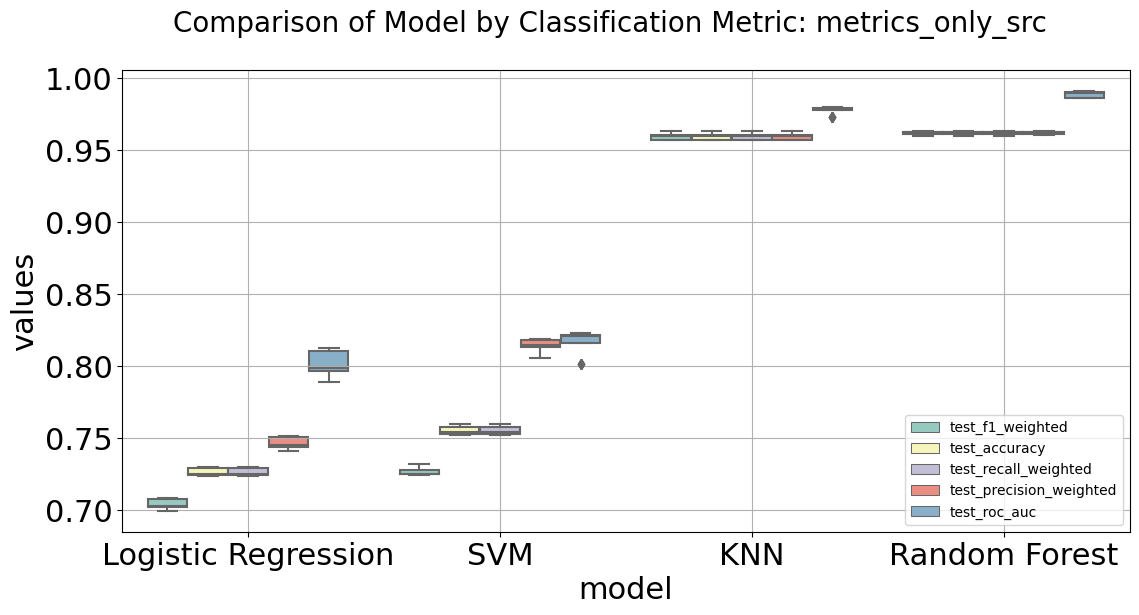

In [117]:
draw_metrics(final_src, "metrics_only_src")

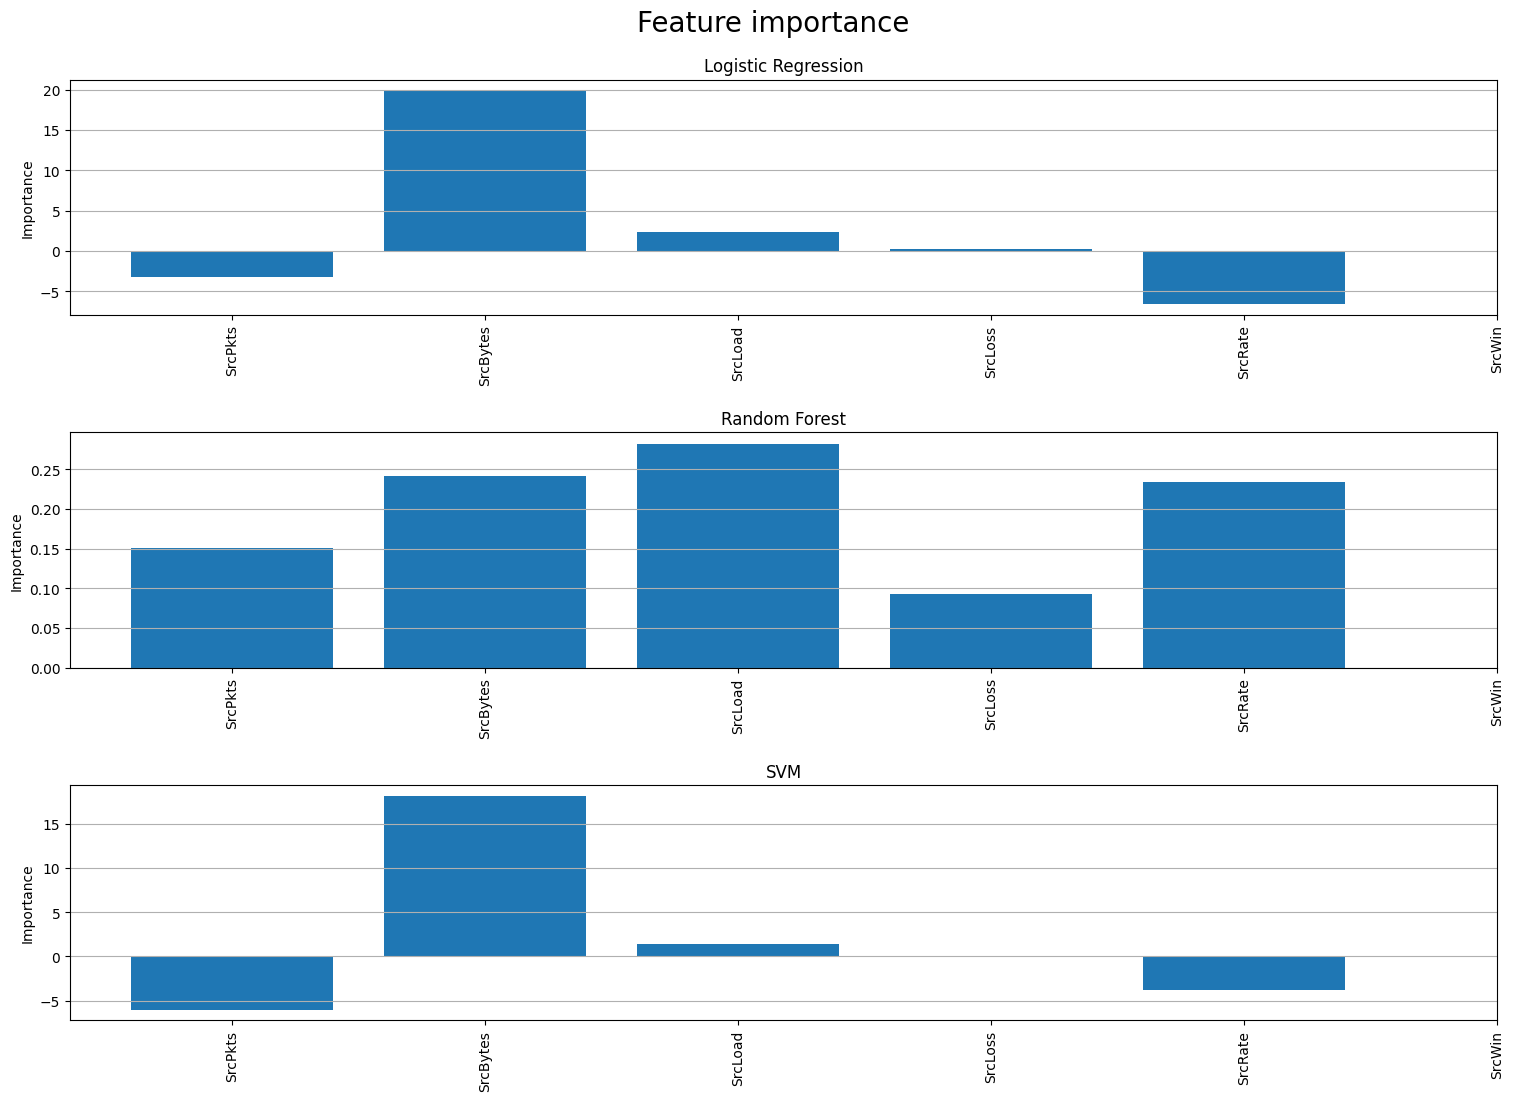

In [167]:
feature_importance(features_src, src_X, "only_src_features")

### Only Destination features

In [120]:
dst_X = X[['DstPkts', 'DstBytes', 'DstLoad', 'DstRate', 'DstWin']]

Model  Logistic Regression
              precision    recall  f1-score   support

   NotAttack       0.74      0.98      0.85      8863
      Attack       0.95      0.51      0.66      6101

    accuracy                           0.79     14964
   macro avg       0.85      0.74      0.75     14964
weighted avg       0.83      0.79      0.77     14964

Model  Random Forest
              precision    recall  f1-score   support

   NotAttack       0.91      0.99      0.95      8863
      Attack       0.98      0.86      0.92      6101

    accuracy                           0.94     14964
   macro avg       0.95      0.93      0.93     14964
weighted avg       0.94      0.94      0.94     14964

Model  KNN
              precision    recall  f1-score   support

   NotAttack       0.95      0.98      0.97      8863
      Attack       0.97      0.93      0.95      6101

    accuracy                           0.96     14964
   macro avg       0.96      0.95      0.96     14964
weighted avg   

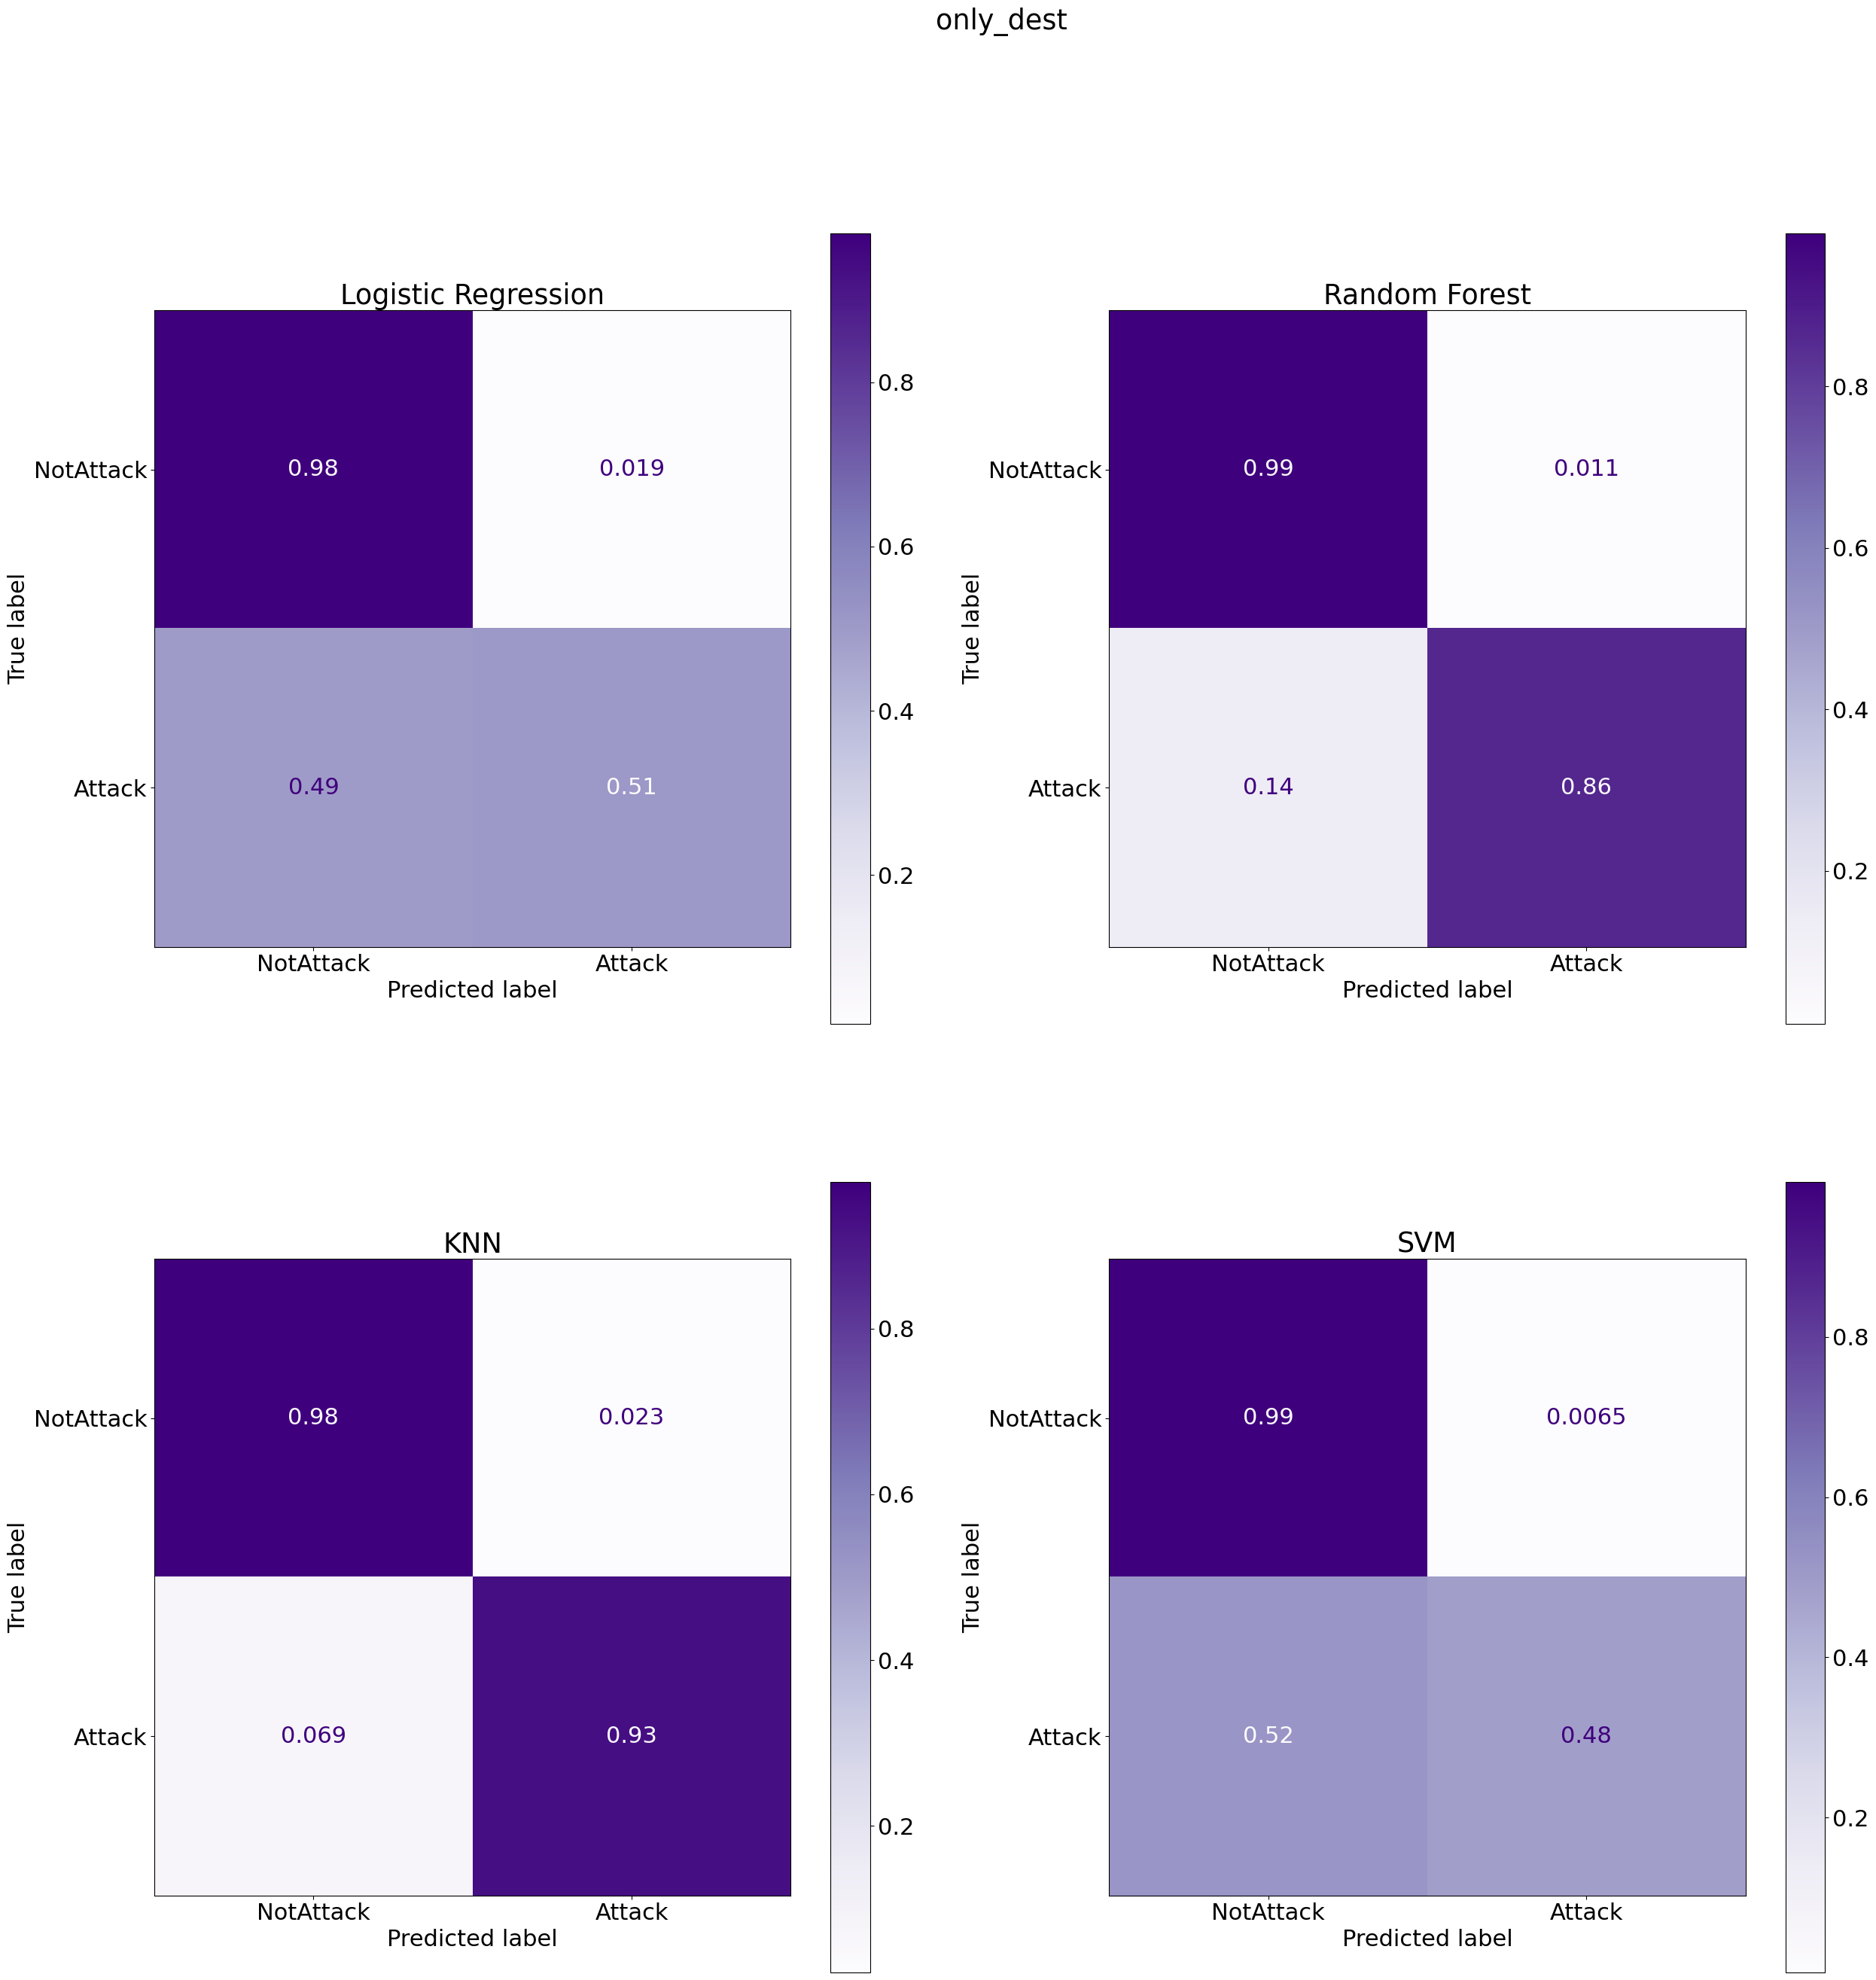

In [190]:
X_train, X_test, y_train, y_test = train_test_split(dst_X, y, test_size=0.40, random_state=8675309, shuffle=True)
final_dst, features_dst = run_exps(X_train, y_train, X_test, y_test, "only_dest")

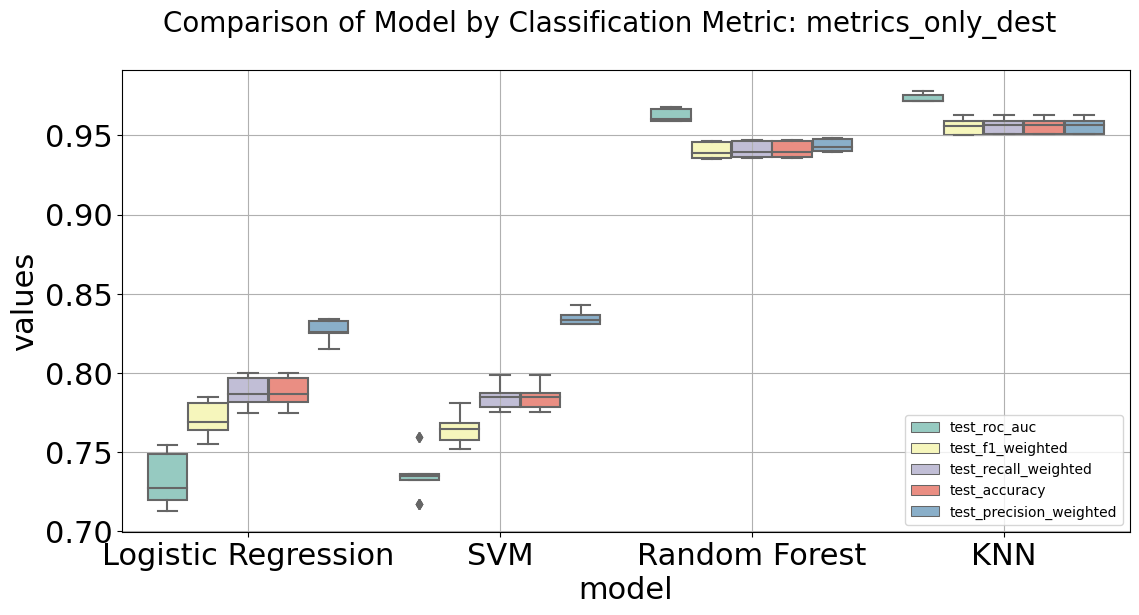

In [126]:
draw_metrics(final_dst, "metrics_only_dest")

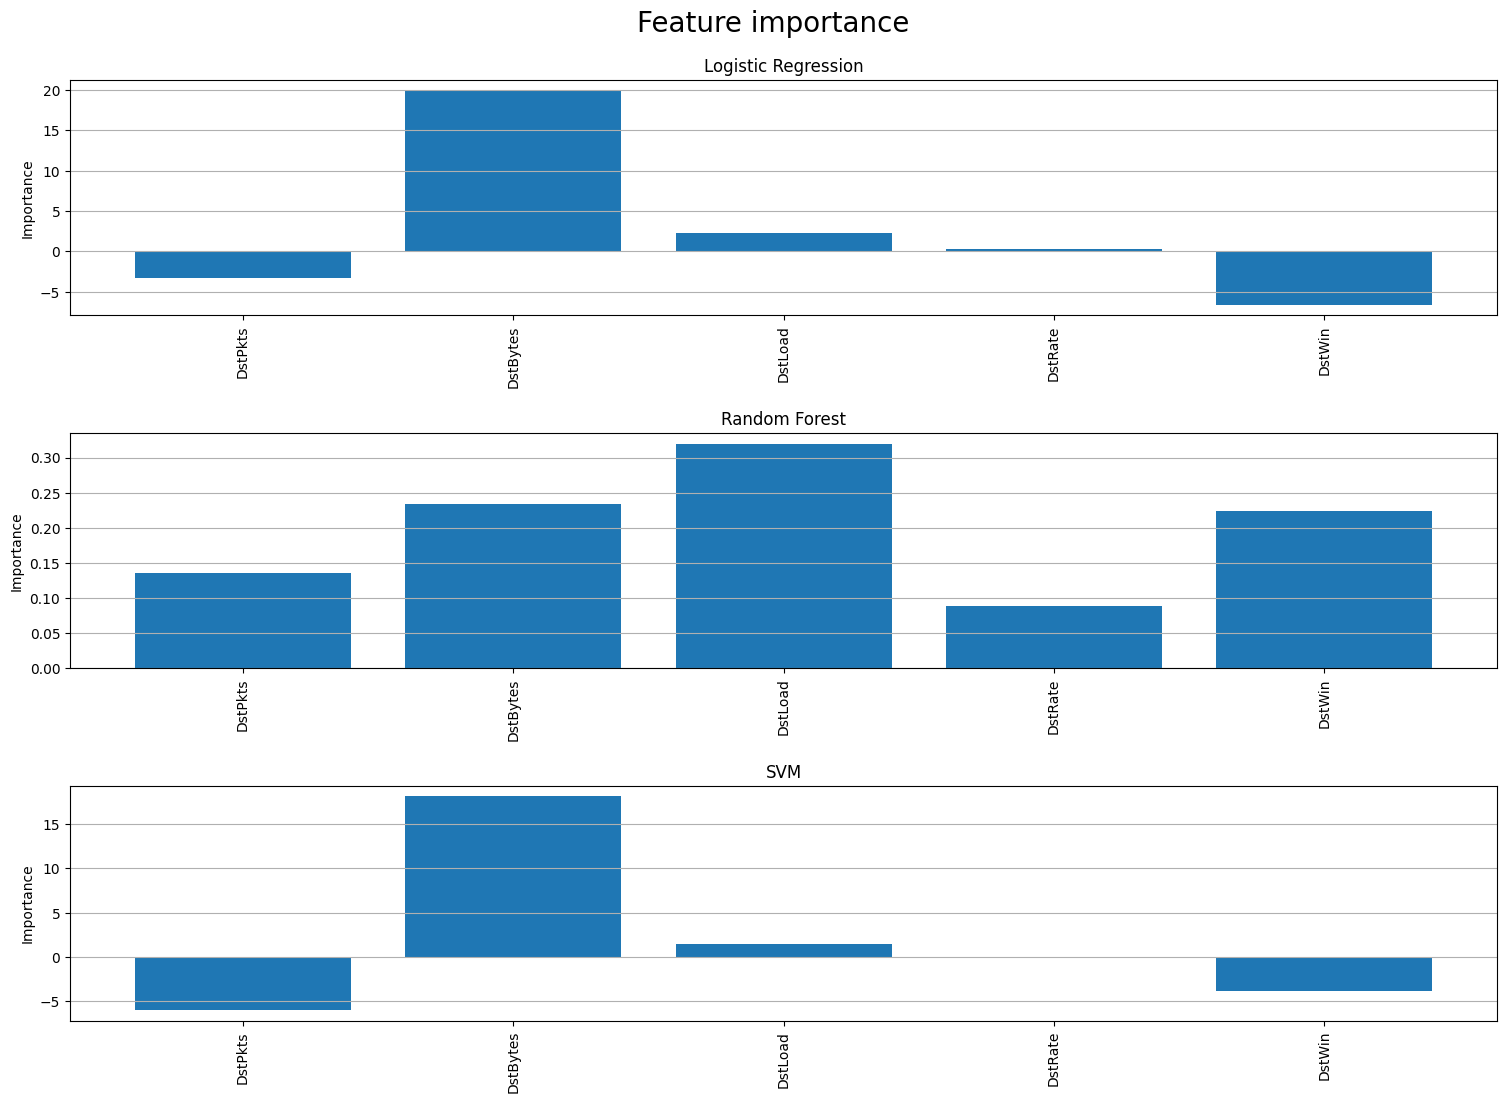

In [168]:
feature_importance(features_dst, dst_X, "only_dest_features")

### Logistic Regression best features

In [188]:
best_X = X[['DstPkts', 'DstBytes', 'Loss', 'State_REQ', 'State_FIN', 'DstWin', 'AckDat']]

Model  Logistic Regression
              precision    recall  f1-score   support

   NotAttack       0.83      0.96      0.89      8863
      Attack       0.93      0.71      0.81      6101

    accuracy                           0.86     14964
   macro avg       0.88      0.84      0.85     14964
weighted avg       0.87      0.86      0.86     14964

Model  Random Forest
              precision    recall  f1-score   support

   NotAttack       0.95      0.99      0.97      8863
      Attack       0.99      0.92      0.95      6101

    accuracy                           0.96     14964
   macro avg       0.97      0.96      0.96     14964
weighted avg       0.96      0.96      0.96     14964

Model  KNN
              precision    recall  f1-score   support

   NotAttack       0.97      0.99      0.98      8863
      Attack       0.99      0.96      0.97      6101

    accuracy                           0.98     14964
   macro avg       0.98      0.97      0.98     14964
weighted avg   

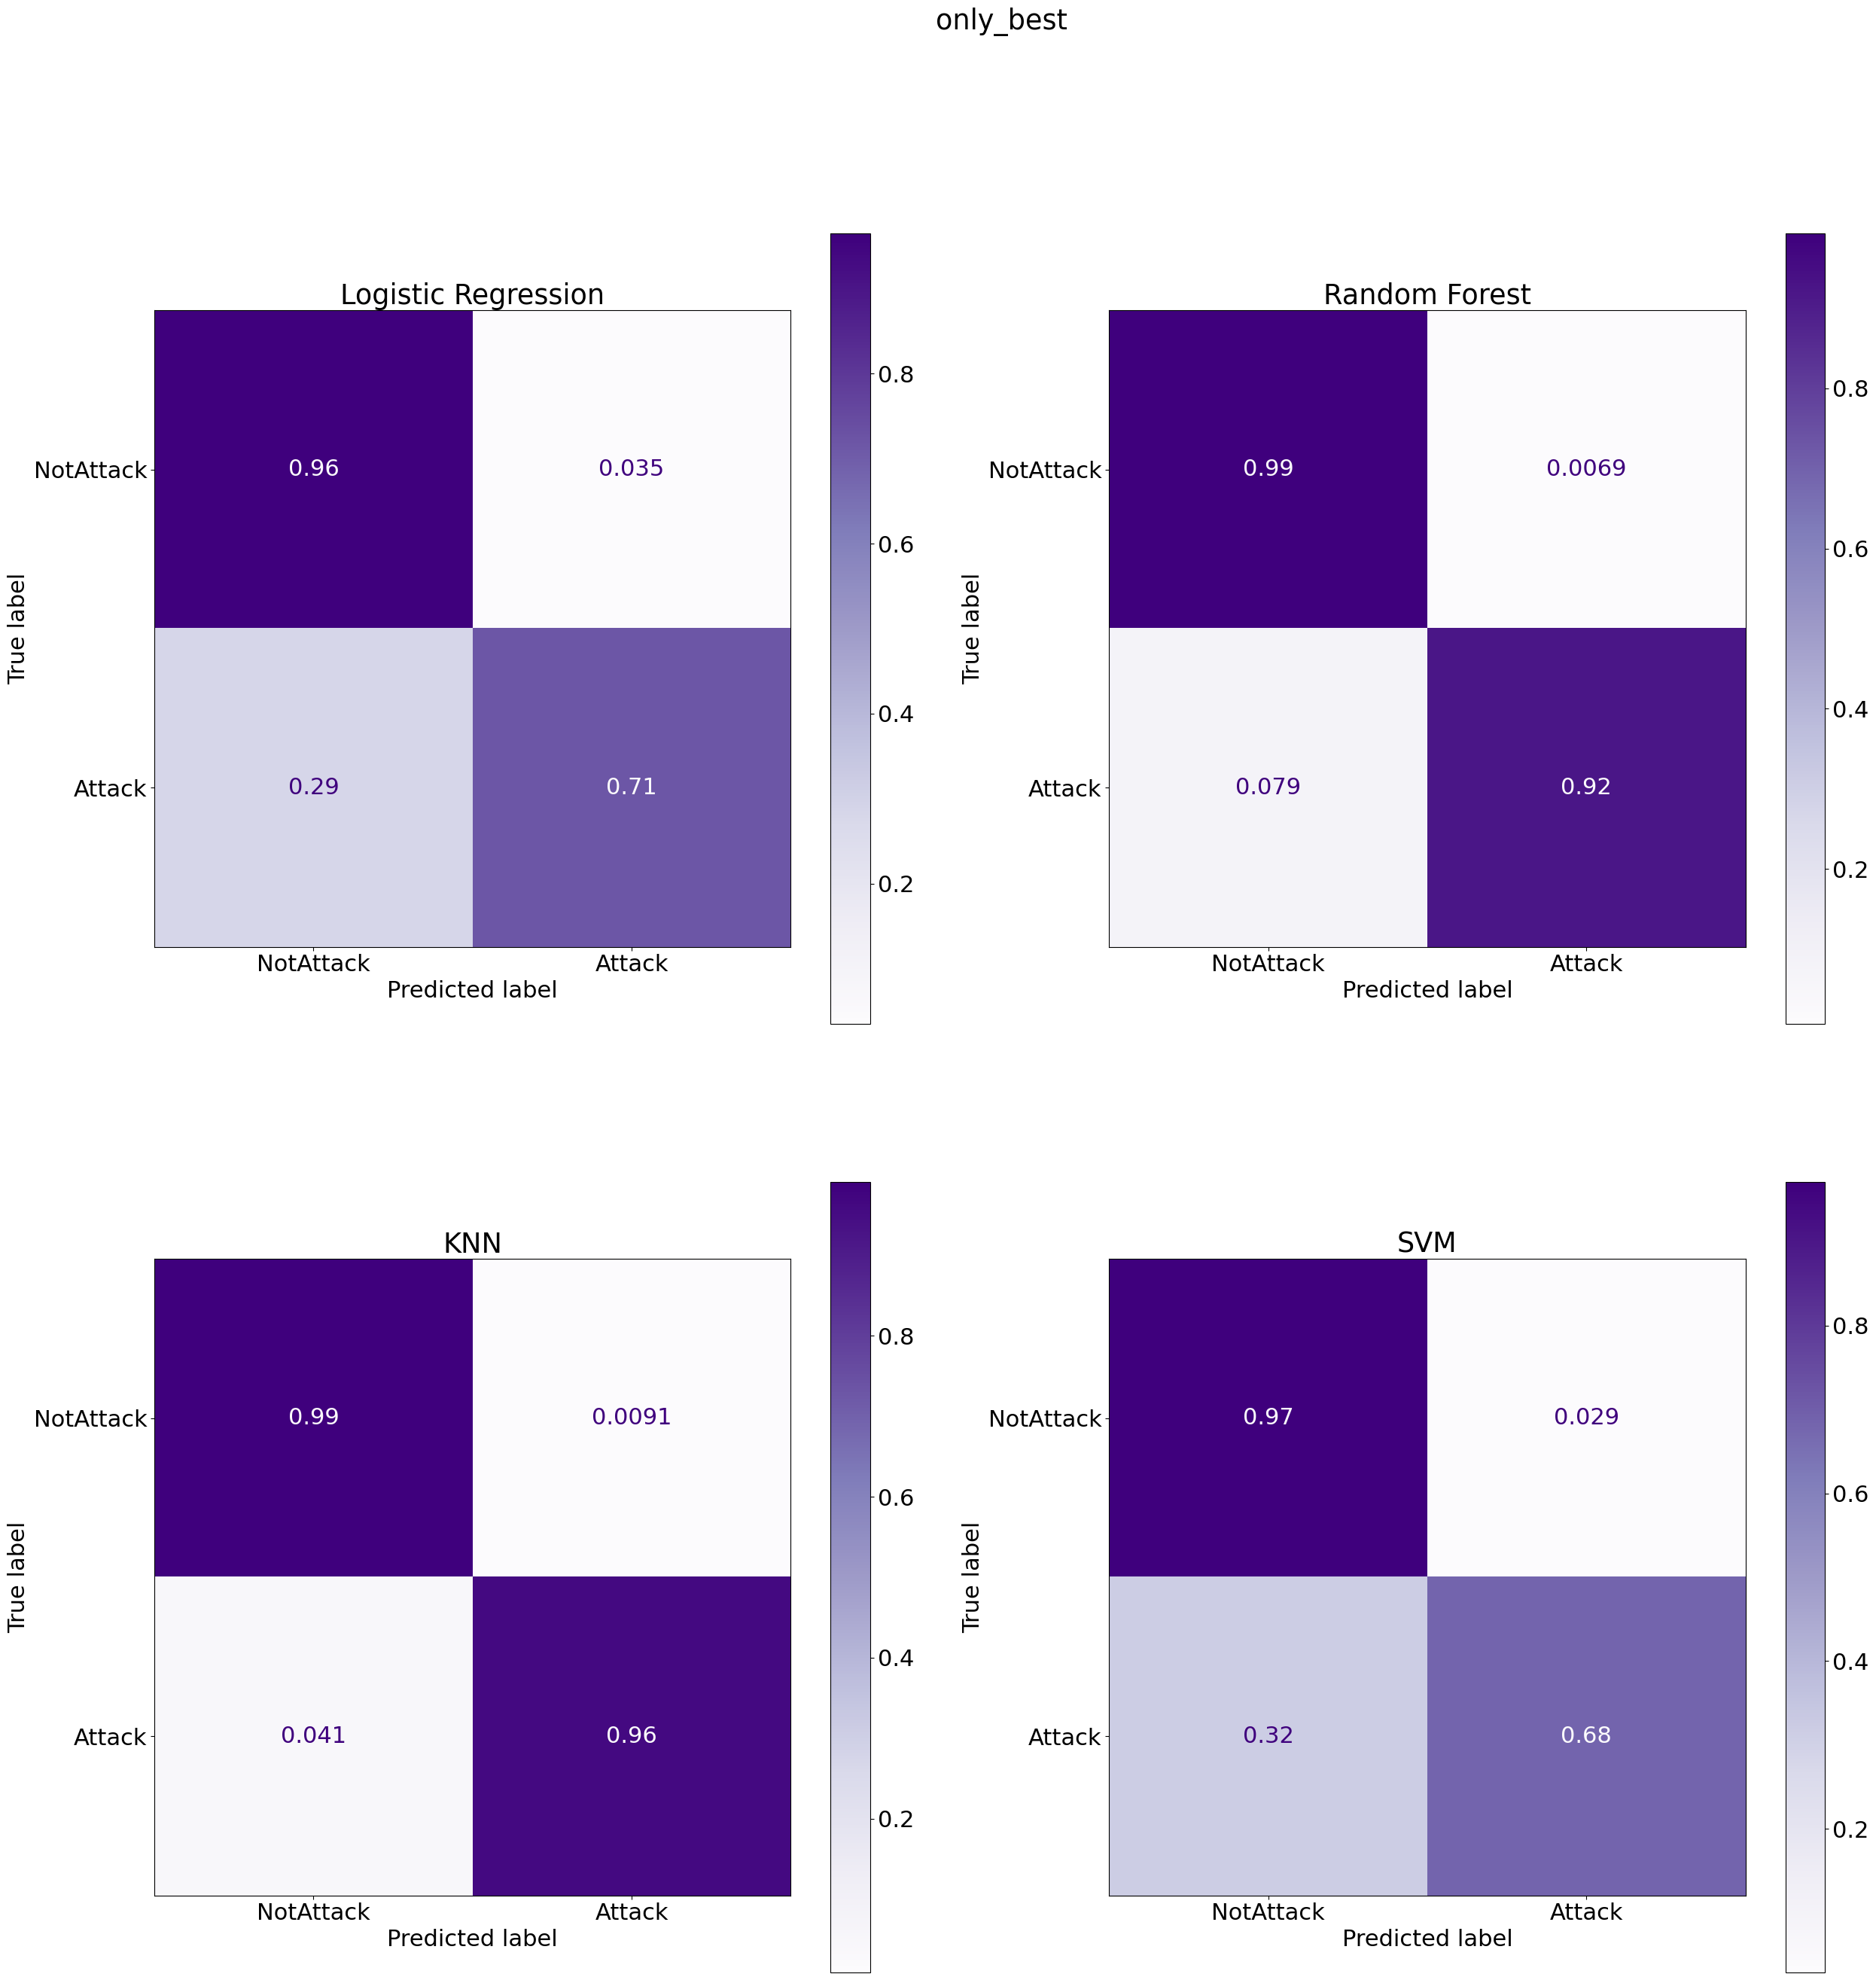

In [191]:
X_train, X_test, y_train, y_test = train_test_split(best_X, y, test_size=0.40, random_state=8675309, shuffle=True)
final_best, features_best = run_exps(X_train, y_train, X_test, y_test, "only_best")

### Result comparison: Features

In [196]:
merged_results = pd.DataFrame()

merged_results["all"] = final.groupby("model").mean()["test_accuracy"]
merged_results["src"] = final_src.groupby("model").mean()["test_accuracy"]
merged_results["dst"] = final_dst.groupby("model").mean()["test_accuracy"]
merged_results["best"] = final_best.groupby("model").mean()["test_accuracy"]
merged_results["all_std"] = final.groupby("model").std()["test_accuracy"]
merged_results["src_std"] = final_src.groupby("model").std()["test_accuracy"]
merged_results["dst_std"] = final_dst.groupby("model").std()["test_accuracy"]
merged_results["best_std"] = final_best.groupby("model").std()["test_accuracy"]

merged_results

,all,src,dst,best,all_std,src_std,dst_std,best_std
model,,,,,,,,
KNN,0.976477,0.959503,0.957008,0.976522,0.002782,0.002495,0.004447,0.002968
Logistic Regression,0.907422,0.726009,0.786198,0.856188,0.002468,0.002567,0.009176,0.005959
Random Forest,0.983293,0.961730,0.940836,0.962532,0.002270,0.001295,0.004079,0.002686
SVM,0.913615,0.755279,0.785084,0.848035,0.003057,0.003237,0.009085,0.006567


In [202]:
models = merged_results.index
plt.bar()

TypeError: bar() missing 2 required positional arguments: 'x' and 'height'

### Learning curves 

In [222]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), score=None, img_name=None):
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, 
                                                                          X, y, cv=cv, n_jobs=n_jobs,
                                                                           train_sizes=train_sizes,
                                                                           return_times=True,  scoring=score)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(score)
    
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    #axes.set_ylim([.94,.99])
    
    plt.suptitle(img_name)
    plt.savefig("images/{}.png".format(img_name))
    return plt

Logistic Regression learning curves started
Split done
DONE!
--------------------

Random Forest learning curves started
Split done
DONE!
--------------------



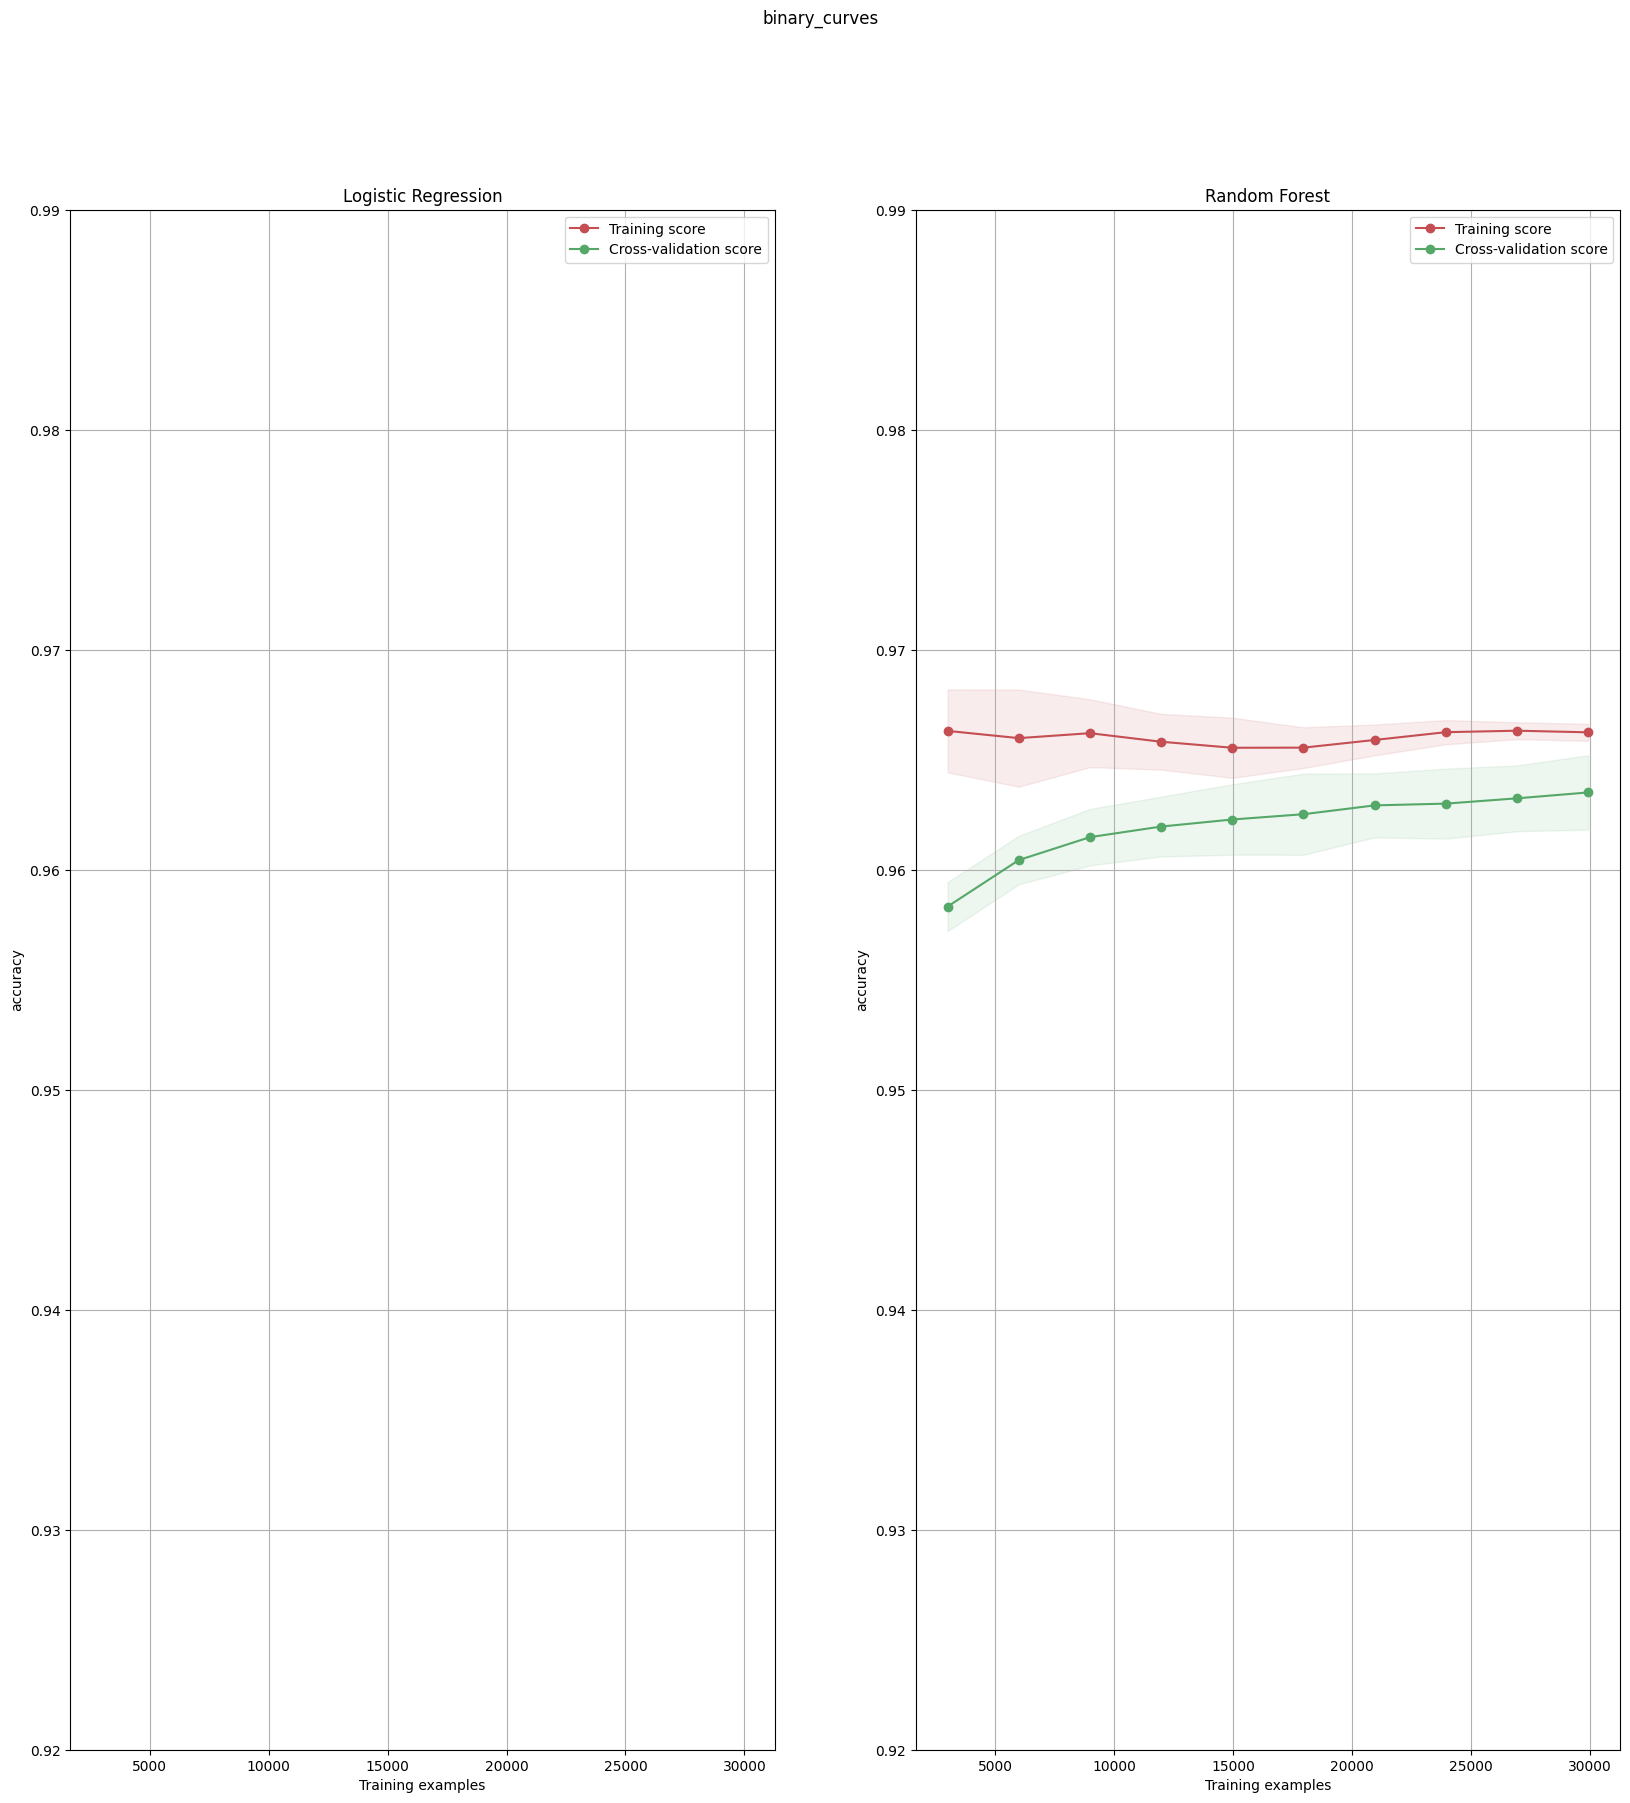

In [216]:
# y = df.Type
# X = df.drop(['Type', 'Sensor'] , axis=1)
mpl.rcParams.update(mpl.rcParamsDefault)

SPLITS = 5
TEST_SIZE = 0.20
TRAIN_SIZE = np.linspace(.1, 1.0, 10)

fig, axes = plt.subplots(round(len(models)/2), 2, figsize=(20,20))

for mod, ax in zip(models, axes.flat):
    title = mod[0]
    print("{} learning curves started".format(title))
    cv = ShuffleSplit(n_splits=SPLITS, test_size=TEST_SIZE, random_state=123123)
    print("Split done")
    plot_learning_curve(mod[1], title, best_X, y, cv=cv, train_sizes=TRAIN_SIZE, axes=ax, score="accuracy", img_name="binary_curves")
    print("DONE!")
    print("-"*20)
    print()


plt.show()

<module 'matplotlib.pyplot' from '/home/antedo/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

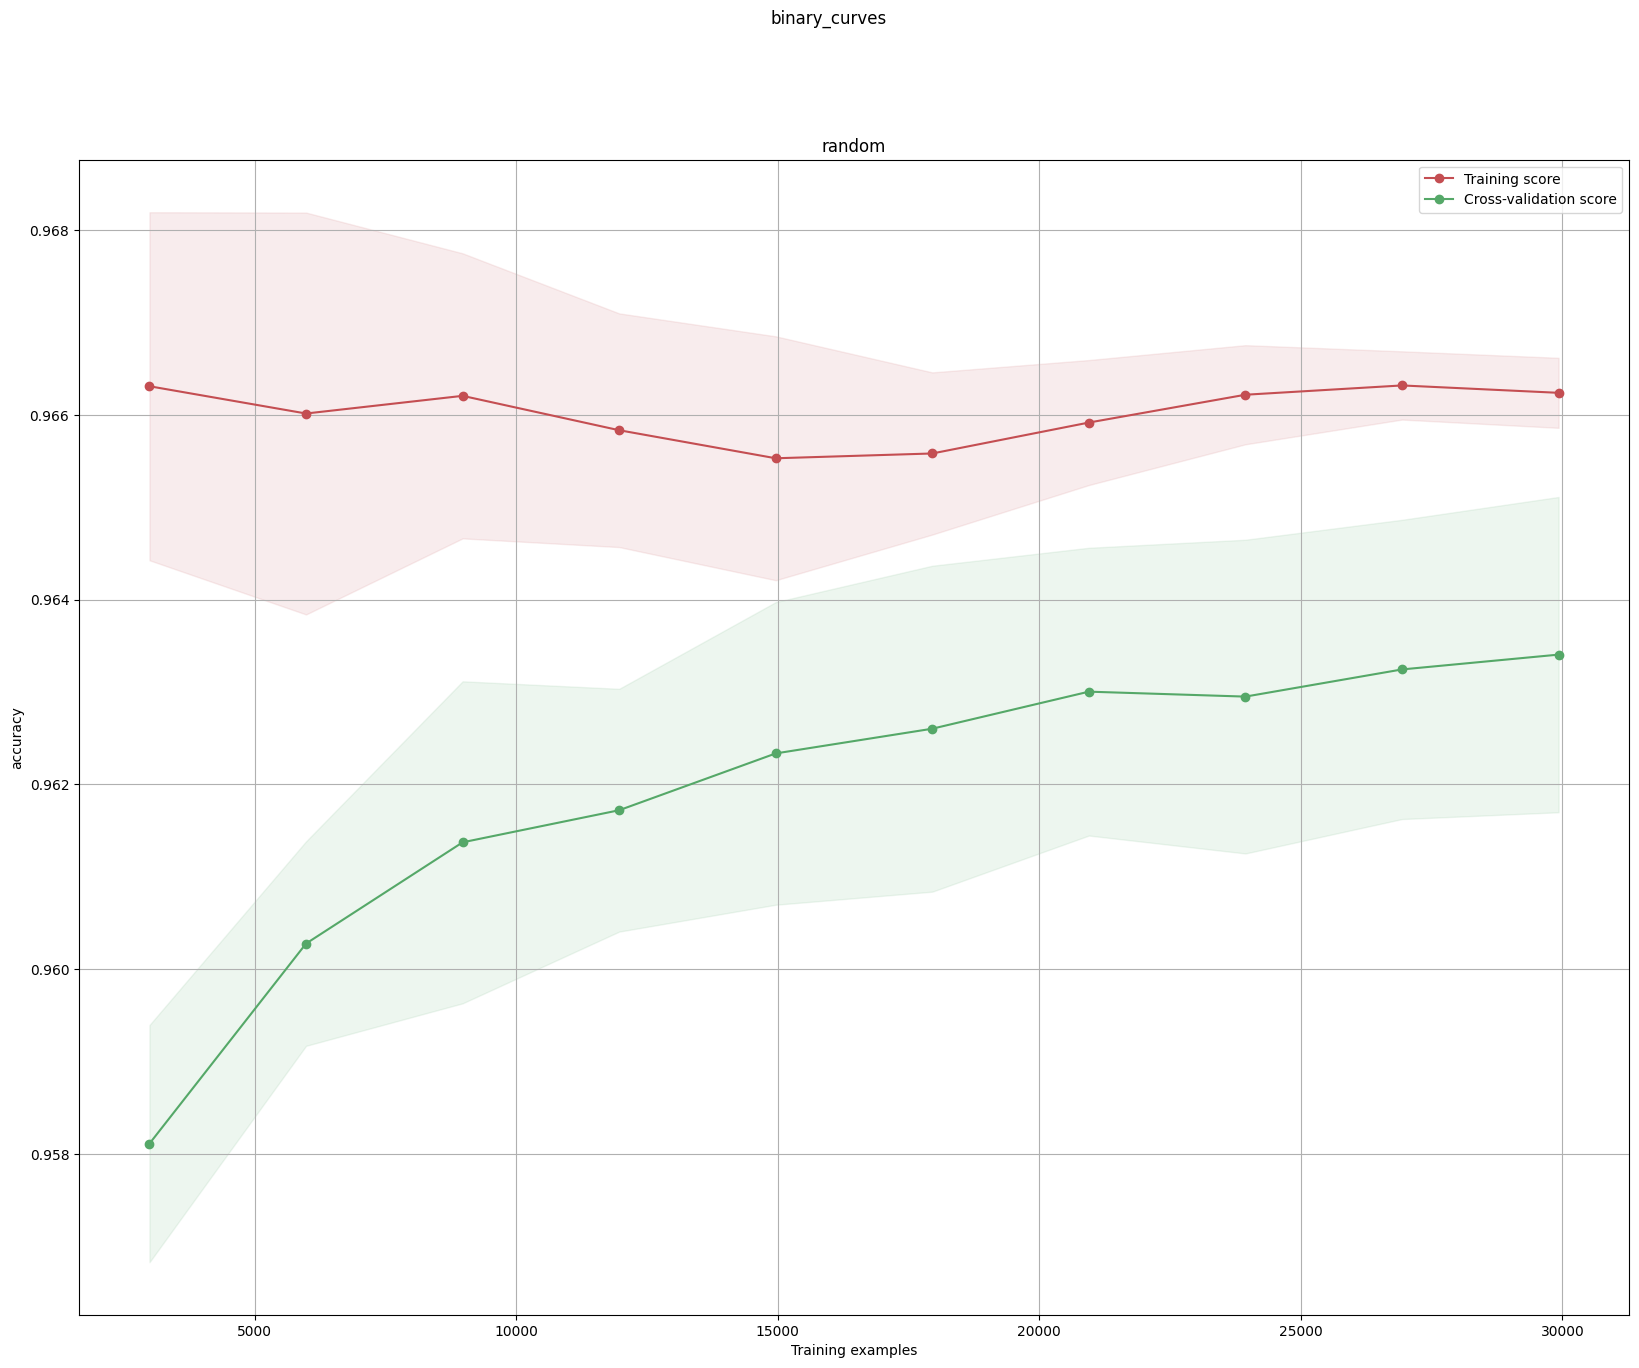

In [223]:
fig, axes = plt.subplots(1,1, figsize=(20,15))

plot_learning_curve(RandomForestClassifier(), "random", best_X, y, cv=cv, train_sizes=TRAIN_SIZE, axes=axes, score="accuracy", img_name="binary_curves")